# Replicate

>[Replicate](https://replicate.com/blog/machine-learning-needs-better-tools) runs machine learning models in the cloud. We have a library of open-source models that you can run with a few lines of code. If you're building your own machine learning models, Replicate makes it easy to deploy them at scale.

This example goes over how to use LangChain to interact with `Replicate` [models](https://replicate.com/explore)

## Setup

In [1]:
# magics to auto-reload external modules in case you are making changes to langchain while working on this notebook
%load_ext autoreload
%autoreload 2

To run this notebook, you'll need to create a [replicate](https://replicate.com) account and install the [replicate python client](https://github.com/replicate/replicate-python).

In [2]:
!pip install replicate


[notice] A new release of pip is available: 23.1.2 -> 23.2
[notice] To update, run: pip install --upgrade pip


In [3]:
# get a token: https://replicate.com/account

from getpass import getpass

REPLICATE_API_TOKEN = getpass()

In [4]:
import os

os.environ["REPLICATE_API_TOKEN"] = REPLICATE_API_TOKEN

In [5]:
from langchain.llms import Replicate
from langchain import PromptTemplate, LLMChain

## Calling a model

Find a model on the [replicate explore page](https://replicate.com/explore), and then paste in the model name and version in this format: model_name/version.

For example, here is [`LLama-V2`](https://replicate.com/a16z-infra/llama13b-v2-chat).

In [6]:
llm = Replicate(
    model="a16z-infra/llama13b-v2-chat:df7690f1994d94e96ad9d568eac121aecf50684a0b0963b25a41cc40061269e5",
    input={"temperature": 0.75, "max_length": 500, "top_p": 1},
)
prompt = """
User: Answer the following yes/no question by reasoning step by step. Can a dog drive a car?
Assistant:
"""
llm(prompt)

'1. Can a dog operate a vehicle? No.\n2. Do dogs have hands to manipulate the pedals and steering wheel? No.\n3. Can dogs see well enough to drive? No.\n4. Does a dog have the cognitive ability to understand traffic laws and make safe driving decisions? No.\n\nTherefore, the answer is no, a dog cannot drive a car.'

As another example, for this [dolly model](https://replicate.com/replicate/dolly-v2-12b), click on the API tab. The model name/version would be: `replicate/dolly-v2-12b:ef0e1aefc61f8e096ebe4db6b2bacc297daf2ef6899f0f7e001ec445893500e5`

Only the `model` param is required, but we can add other model params when initializing.

For example, if we were running stable diffusion and wanted to change the image dimensions:

```
Replicate(model="stability-ai/stable-diffusion:db21e45d3f7023abc2a46ee38a23973f6dce16bb082a930b0c49861f96d1e5bf", input={'image_dimensions': '512x512'})
```
                       
*Note that only the first output of a model will be returned.*

In [26]:
llm = Replicate(
    model="replicate/dolly-v2-12b:ef0e1aefc61f8e096ebe4db6b2bacc297daf2ef6899f0f7e001ec445893500e5"
)

In [27]:
prompt = """
Answer the following yes/no question by reasoning step by step. 
Can a dog drive a car?
"""
llm(prompt)

'It depends on how you define "can". Because dogs do have four legs, they are clearly able to move around in a car; it might even be possible for them to drive given proper training and enough motivation (e.g., food or comfort). From a legal perspective however, there are many reasons why this would not make sense at all: Dogs lack some of the vital capabilities required to safely operate a vehicle; their behaviour may differ significantly compared to humans due to their weaker cognitive abilities versus ours; and there could also exist valid concerns about safety since we don\'t really know what happens when two species with different psychological characteristics are put together under stressful conditions. Therefore, no, a dog cannot legally drive a car.\n\n'

We can call any replicate model using this syntax. For example, we can call stable diffusion.

In [28]:
text2image = Replicate(
    model="stability-ai/stable-diffusion:db21e45d3f7023abc2a46ee38a23973f6dce16bb082a930b0c49861f96d1e5bf",
    input={"image_dimensions": "512x512"},
)

In [29]:
image_output = text2image("A cat riding a motorcycle by Picasso")
image_output

'https://replicate.delivery/pbxt/j0nlxW0aoh7LExWGfdvyfgkmKA2GQWcF6e1wkYNWfoSakkHFB/out-0.png'

The model spits out a URL. Let's render it.

In [21]:
!pip install Pillow

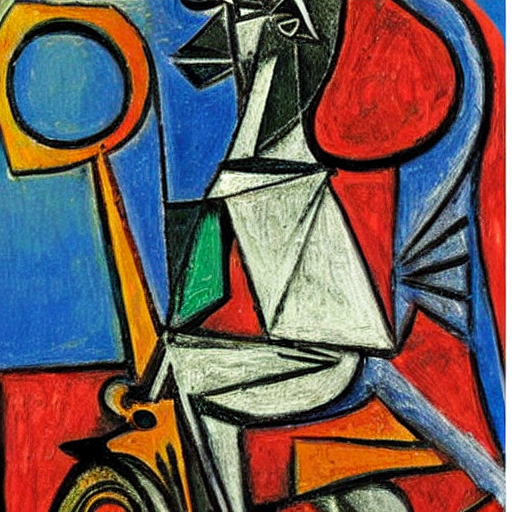

In [30]:
from PIL import Image
import requests
from io import BytesIO

response = requests.get(image_output)
img = Image.open(BytesIO(response.content))

img

## Streaming Response
You can optionally stream the response as it is produced, which is helpful to show interactivity to users for time-consuming generations. See detailed docs on [Streaming](https://python.langchain.com/docs/modules/model_io/models/llms/how_to/streaming_llm) for more information.

In [34]:
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler

llm = Replicate(
    streaming=True,
    callbacks=[StreamingStdOutCallbackHandler()],
    model="a16z-infra/llama13b-v2-chat:df7690f1994d94e96ad9d568eac121aecf50684a0b0963b25a41cc40061269e5",
    input={"temperature": 0.75, "max_length": 500, "top_p": 1},
)
prompt = """
User: Answer the following yes/no question by reasoning step by step. Can a dog drive a car?
Assistant:
"""
_ = llm(prompt)

1. Dogs do not have the ability to operate complex machinery, such as cars.
2. Dogs do not have the cognitive ability to understand the concept of driving.
3. Dogs do not have the physical ability to reach the pedals or steering wheel of a car.
4. Dogs do not have the ability to communicate their intentions to other drivers or pedestrians.

Therefore, the answer is no, a dog cannot drive a car.

## Chaining Calls
The whole point of langchain is to... chain! Here's an example of how do that.

In [14]:
from langchain.chains import SimpleSequentialChain

First, let's define the LLM for this model as a flan-5, and text2image as a stable diffusion model.

In [15]:
dolly_llm = Replicate(
    model="replicate/dolly-v2-12b:ef0e1aefc61f8e096ebe4db6b2bacc297daf2ef6899f0f7e001ec445893500e5"
)
text2image = Replicate(
    model="stability-ai/stable-diffusion:db21e45d3f7023abc2a46ee38a23973f6dce16bb082a930b0c49861f96d1e5bf"
)

First prompt in the chain

In [16]:
prompt = PromptTemplate(
    input_variables=["product"],
    template="What is a good name for a company that makes {product}?",
)

chain = LLMChain(llm=dolly_llm, prompt=prompt)

Second prompt to get the logo for company description

In [17]:
second_prompt = PromptTemplate(
    input_variables=["company_name"],
    template="Write a description of a logo for this company: {company_name}",
)
chain_two = LLMChain(llm=dolly_llm, prompt=second_prompt)

Third prompt, let's create the image based on the description output from prompt 2

In [18]:
third_prompt = PromptTemplate(
    input_variables=["company_logo_description"],
    template="{company_logo_description}",
)
chain_three = LLMChain(llm=text2image, prompt=third_prompt)

Now let's run it!

In [19]:
# Run the chain specifying only the input variable for the first chain.
overall_chain = SimpleSequentialChain(
    chains=[chain, chain_two, chain_three], verbose=True
)
catchphrase = overall_chain.run("colorful socks")
print(catchphrase)



> Entering new SimpleSequentialChain chain...
 colorsocks.com


A stylized letter "s" in red, white and blue colors with a bright light shining through it, reminiscent of the sunlight streaming through a clear summer sky.



https://replicate.delivery/pbxt/Qau0h94c8e1xX6DnW4tHubR5vmdrdXJZh39cycjrjb3Wf3RRA/out-0.png

> Finished chain.
https://replicate.delivery/pbxt/Qau0h94c8e1xX6DnW4tHubR5vmdrdXJZh39cycjrjb3Wf3RRA/out-0.png


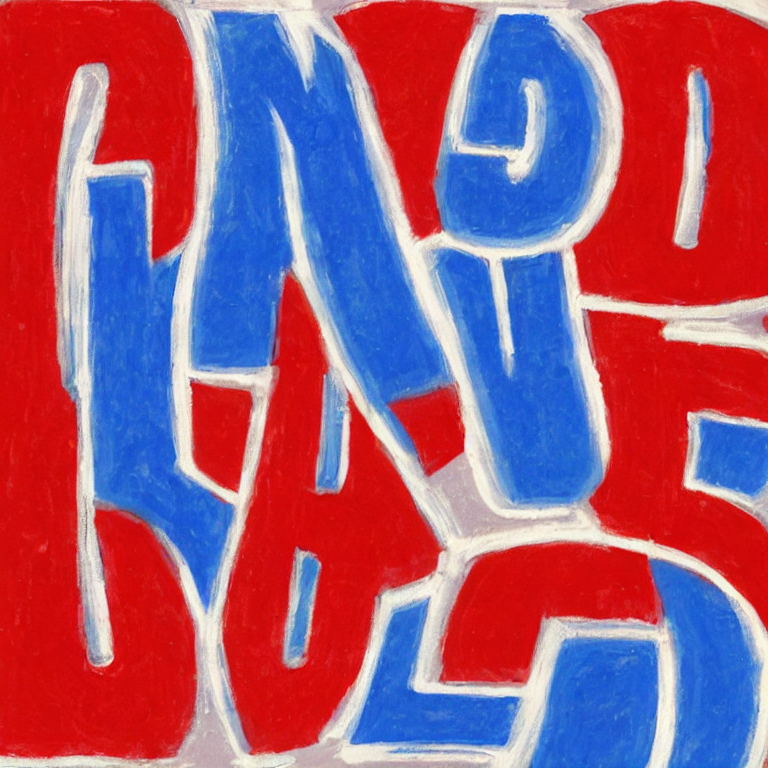

In [24]:
response = requests.get(
    "https://replicate.delivery/pbxt/Qau0h94c8e1xX6DnW4tHubR5vmdrdXJZh39cycjrjb3Wf3RRA/out-0.png"
)
img = Image.open(BytesIO(response.content))
img